# SN 2022abik 2022-12-1415

* [TNS Page for SN 2022abik](https://www.wis-tns.org/object/2022abik)

### Observing Notes

Another round of 30 60-second exposures each in g', r', and i', this time, proceeding across series rather than doing all of g' first.

TheSkyX crashed when approximately 80 of the planned 90 images had been taken.

### Calibration Photos

The calibration photos are in 2022-11-3001.

The bias photos should be discarded in favor of the 1-second (and 30-second) darks. It turns out TheSkyX ignores the exposure time set on bias photos and does some very rapid exposure. I would not have noticed this if I had not needed some 30-second bias files. The 30-second darks were needed because the i' flats required 30 seconds to get a reasonable value. The i' images are not analyzed below.

In [1]:
import os
import numpy as np
from astropy import units as u
from astropy.nddata import CCDData
from astropy.io import fits
from ccdproc import ImageFileCollection, Combiner, combine, subtract_dark, flat_correct
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Only the following three lines should need to be adjusted, typically, from analysis to analysis.

observation_date = '2022-12-1415'
calibration_date = '2022-11-3001'
filters = ['g', 'r']

light_exposure = 60 * u.second
dark_exposure = light_exposure  # our method presumes this equality
flat_exposure = 1 * u.second
bias_exposure = flat_exposure  # our method presumes this equality

In [3]:
# directories where the observation and calibration photos being analyzed are kept

observation_directory = os.path.join(os.path.expanduser('~'), 'Transients', observation_date)
calibration_directory = os.path.join(os.path.expanduser('~'), 'Transients', calibration_date)

In [4]:
# subdirectories -- relative to observation and calibration directories

light_directories = [os.path.join(observation_directory, filter) for filter in filters]

# the 60-second darks
dark_directory = os.path.join(calibration_directory, 'dark')

# the 1-second g and r flats
flat_directories = [os.path.join(calibration_directory, 'flat', filter) for filter in filters]

# the 1-second darks/biases
bias_directory = os.path.join(calibration_directory, 'bias')

light_files_list = [ImageFileCollection(light_directory).files_filtered(include_path='True')
               for light_directory in light_directories]
dark_files = ImageFileCollection(dark_directory).files_filtered(include_path='True')
flat_files_list = [ImageFileCollection(flat_directory).files_filtered(include_path='True')
               for flat_directory in flat_directories]
bias_files = ImageFileCollection(bias_directory).files_filtered(include_path='True')

lights_list = [[CCDData.read(file, unit=u.adu) for file in light_files] for light_files in light_files_list]
darks = [CCDData.read(file, unit=u.adu) for file in dark_files]
flats_list = [[CCDData.read(file, unit=u.adu) for file in flat_files] for flat_files in flat_files_list]
biases = [CCDData.read(file, unit=u.adu) for file in bias_files]

# the aligned directories are written to not read from
aligned_directories = [os.path.join(light_directory, 'aligned') for light_directory in light_directories]

for aligned_directory in aligned_directories:
    if not os.path.exists(aligned_directory):
        os.makedirs(aligned_directory)


Set OBSGEO-Y to -4483197.997 from OBSGEO-[LBH].
Set OBSGEO-Z to  3851226.198 from OBSGEO-[LBH]'. [astropy.wcs.wcs]
Set OBSGEO-Y to -4483197.997 from OBSGEO-[LBH].
Set OBSGEO-Z to  3851226.198 from OBSGEO-[LBH]'.


### Visualization

In [5]:
# Log Stretch Utility

from math import log10, floor

def log_stretch_transform(black_point, saturation_range):
    
    log_saturation_range = log10(saturation_range)
    
    def fn(pixel_value):
        pixel_value -= black_point
        # The bizarre first conditional test on the next line avoids any attempt to transform NaNs.
        if pixel_value != pixel_value or pixel_value <= 1.0:
            return 0
        else:
            log_pixel_value = log10(pixel_value)
            if log_pixel_value >= log_saturation_range:
                return 255;
            else:
                return floor(256 * log_pixel_value / log_saturation_range)
        
    return fn


In [6]:
sample_images = [lights[0] for lights in lights_list]

Per the [CCDData documentation](https://docs.astropy.org/en/stable/api/astropy.nddata.CCDData.html)
we should get the data out of the CCDData file as follows:

In [7]:
sample_data = [np.asarray(sample_image) for sample_image in sample_images]

#### Median Subtraction

In [8]:
medians = [np.median(sample, axis=1, keepdims=True) for sample in sample_data]
subtracted = [sample_data[i] - medians[i] for i in range(len(filters))]

#### Log Stretch

In [9]:
stretch_function = log_stretch_transform(7, 300)
transform = np.vectorize(stretch_function)
transformed = [transform(data) for data in subtracted]

#### Display of an Uncalibrated g' and an Uncalibrated r' Image

The displays below are north-down because this object was in the west. The first is with the g' filter and the second is with r'.

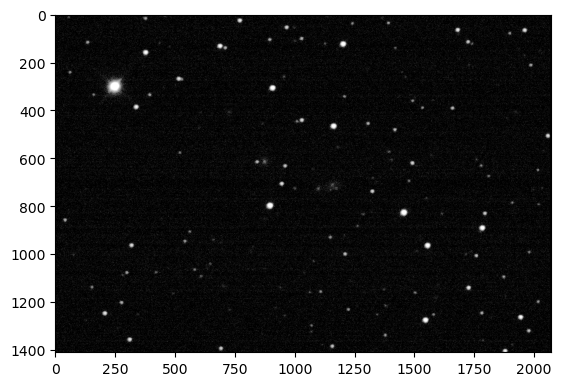

In [10]:
plt.imshow(transformed[0], cmap='gray')

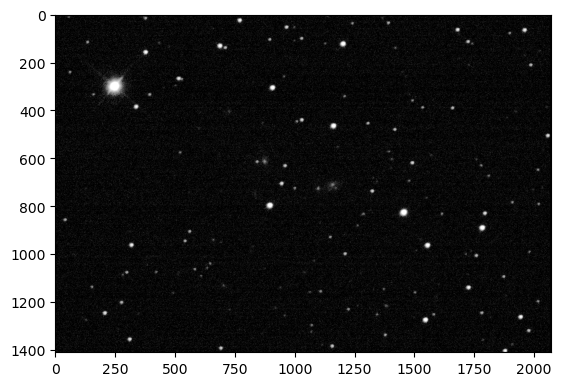

In [11]:
plt.imshow(transformed[1], cmap='gray')

Compare with [TheSkyX chart, half-frame, north-down](https://brianhill.github.io/transient-astronomy/targets/SN_2022abik/target/TheSkyXScreenshot-HalfFrame-NorthDown.png).